In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall


In [2]:
import zipfile
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip files
zip_paths = ['/content/drive/My Drive/PSL/train.zip',
             '/content/drive/My Drive/PSL/test.zip',
             '/content/drive/My Drive/PSL/valid.zip']

# Extraction paths
extract_to = ['/content/train/',
              '/content/test/',
              '/content/valid/']

# Create directories if they don't exist
for path in extract_to:
    os.makedirs(path, exist_ok=True)

# Extract the zip files
for zip_path, extract_path in zip(zip_paths, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extraction Complete")


Mounted at /content/drive
Extraction Complete


In [ ]:
# Define the directory containing your dataset
dataset_dir = '/content/train/train/labels'  # Update this with your dataset directory

# Initialize an empty dictionary to store class distribution
class_distribution = {}

# List contents of the dataset directory
# print("Contents of the dataset directory:")
# print(os.listdir(dataset_dir))

# Iterate over the files in the dataset directory
for file_name in os.listdir(dataset_dir):
    if file_name.endswith('.txt'):
        # Extract class name from file name
        class_name = file_name.split('_')[0]
        class_distribution[class_name] = class_distribution.get(class_name, 0) + 1

# Now you have the class distribution
print("\nClass Distribution:")
print(class_distribution)



Class Distribution:
{'Z': 78, 'R': 93, 'V': 84, 'F': 180, 'E': 171, 'T': 87, 'M': 81, 'K': 171, 'J': 168, 'A': 117, 'C': 165, 'H': 189, 'P': 99, 'G': 177, 'X': 84, 'I': 96, 'Q': 90, 'swaad': 42, 'B': 180, 'L': 87, 'U': 90, 'S': 33, 'N': 81, 'D': 198, 'O': 75, 'Y': 75, 'W': 81, 'aliph': 27}


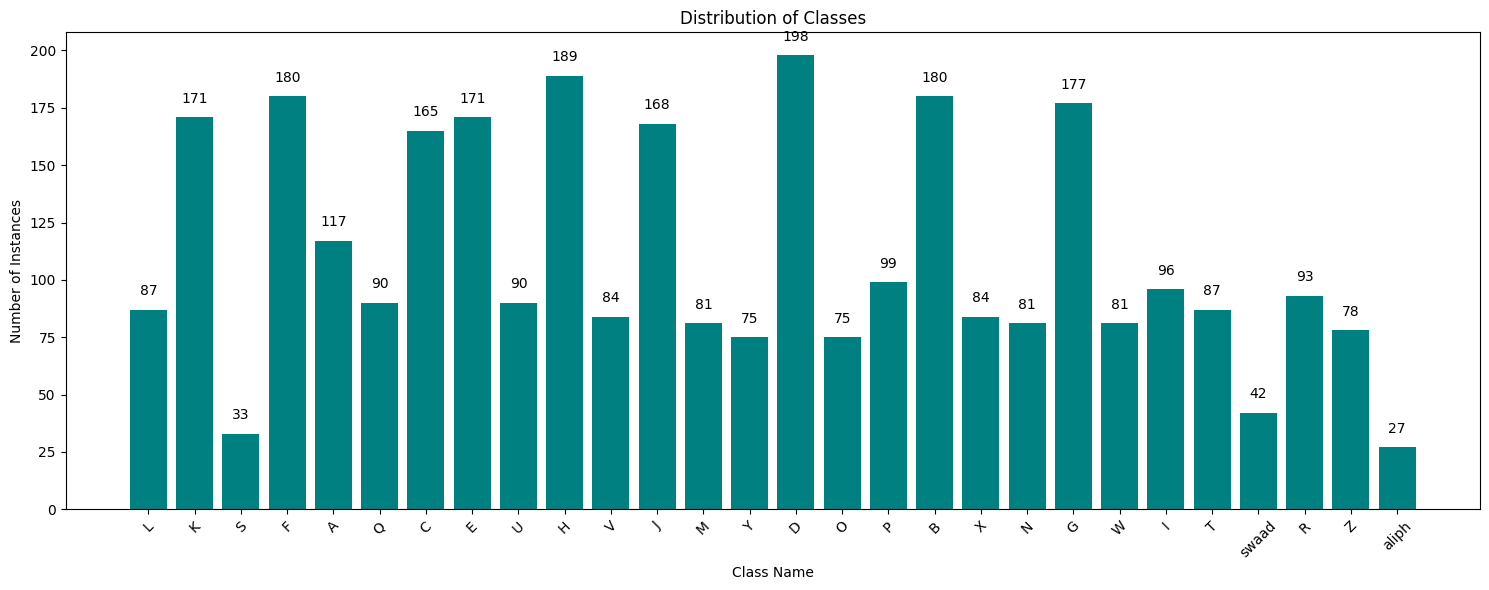

In [ ]:
# Your class distribution data
class_distribution = {'L': 87, 'K': 171, 'S': 33, 'F': 180, 'A': 117, 'Q': 90, 'C': 165, 'E': 171, 'U': 90,
                      'H': 189, 'V': 84, 'J': 168, 'M': 81, 'Y': 75, 'D': 198, 'O': 75, 'P': 99, 'B': 180,
                      'X': 84, 'N': 81, 'G': 177, 'W': 81, 'I': 96, 'T': 87, 'swaad': 42, 'R': 93, 'Z': 78, 'aliph': 27}

# Bar plotting
plt.figure(figsize=(15, 6))
bars = plt.bar(class_distribution.keys(), class_distribution.values(), color='teal')

# Displaying values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom')

# Labels and title
plt.xlabel('Class Name')
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [3]:
def preprocess_image(image, size=(100, 100), apply_blur=False, invert_contrast=False):
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to remove noise
    if apply_blur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    # Invert contrast
    if invert_contrast:
        image = 255 - image

    # Resize the preprocessed image
    image = cv2.resize(image, size)

    # Ensure the image is in the correct data type
    image = image.astype('uint8')

    return image


In [4]:
def histogramEqualization(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to load image '{image_path}'")
        return None
    equalized_image = cv2.equalizeHist(image)
    return equalized_image


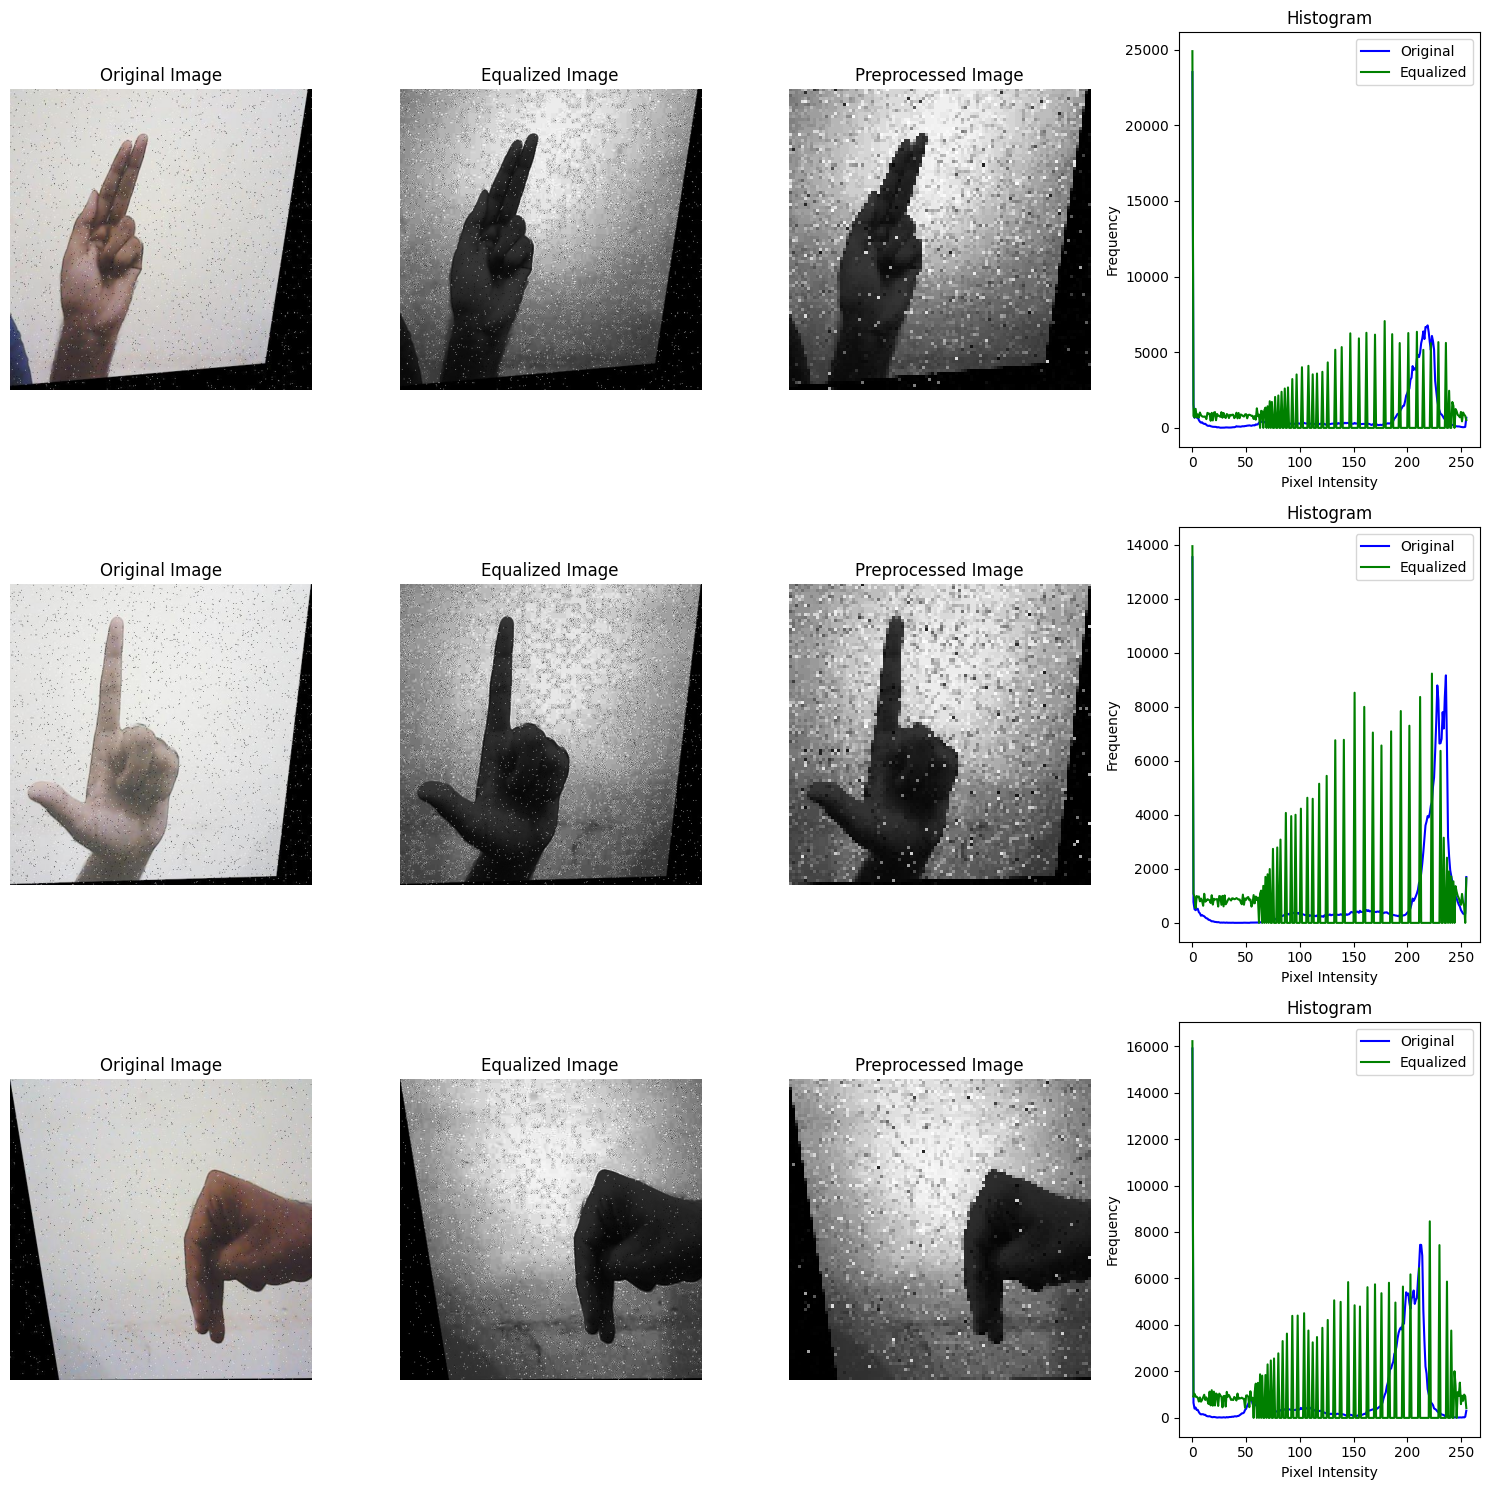

In [9]:
# Load and preprocess random images, apply histogram equalization, and display histograms

# Function to preprocess and display images
def preprocess_and_display_images(image_directory, num_samples_to_display=3):
    # List all files in the directory
    image_files = os.listdir(image_directory)
    if not image_files:
        raise ValueError("No images found in the directory.")

    # Choose random samples from the dataset
    random_samples = random.sample(image_files, num_samples_to_display)

    plt.figure(figsize=(15, 5 * num_samples_to_display))

    for i, image_file in enumerate(random_samples):
        image_path = os.path.join(image_directory, image_file)

        # Read the original image
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Apply histogram equalization
        equalized_image = histogramEqualization(image_path)

        if equalized_image is None:
            continue

        # Display original and equalized images
        plt.subplot(num_samples_to_display, 4, i * 4 + 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 4, i * 4 + 2)
        plt.imshow(equalized_image, cmap='gray')
        plt.title('Equalized Image')
        plt.axis('off')

        # Preprocess the equalized image
        preprocessed_image = preprocess_image(equalized_image)

        # Compute and display histograms for original and preprocessed images
        hist_original = cv2.calcHist([original_image], [0], None, [256], [0, 256])
        hist_equalized = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])
        hist_preprocessed = cv2.calcHist([preprocessed_image], [0], None, [256], [0, 256])

        # Display preprocessed image and its histogram
        plt.subplot(num_samples_to_display, 4, i * 4 + 3)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title('Preprocessed Image')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 4, i * 4 + 4)
        plt.plot(hist_original, color='blue', label='Original')
        plt.plot(hist_equalized, color='green', label='Equalized')
        # plt.plot(hist_preprocessed, color='red', label='Preprocessed')
        plt.title('Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Preprocess and display images
preprocess_and_display_images('/content/train/train/images/', num_samples_to_display=3)

In [ ]:
# Load the dataset
data_dir = '/content/train/train/images'  # Update this with your dataset directory

data = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.jpg'):
        class_name = file_name.split('_')[0]
        image_path = os.path.join(data_dir, file_name)
        data.append({'image_path': image_path, 'label': class_name})

# Preprocess the images
X_data = np.array([preprocess_image(entry['image_path']) for entry in data])

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit([entry['label'] for entry in data])

y_data = to_categorical(label_encoder.transform([entry['label'] for entry in data]))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


In [ ]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
78/78 [==============================] - 52s 644ms/step - loss: 3.2805 - accuracy: 0.0545 - val_loss: 3.2641 - val_accuracy: 0.0677
Epoch 2/30
78/78 [==============================] - 51s 657ms/step - loss: 3.2283 - accuracy: 0.0690 - val_loss: 3.1915 - val_accuracy: 0.1000
Epoch 3/30
78/78 [==============================] - 47s 605ms/step - loss: 3.0853 - accuracy: 0.1150 - val_loss: 3.0101 - val_accuracy: 0.1355
Epoch 4/30
78/78 [==============================] - 47s 603ms/step - loss: 2.9115 - accuracy: 0.1662 - val_loss: 2.8424 - val_accuracy: 0.1839
Epoch 5/30
78/78 [==============================] - 51s 645ms/step - loss: 2.7420 - accuracy: 0.2146 - val_loss: 2.6877 - val_accuracy: 0.2532
Epoch 6/30
78/78 [==============================] - 49s 628ms/step - loss: 2.5700 - accuracy: 0.2626 - val_loss: 2.5356 - val_accuracy: 0.2823
Epoch 7/30
78/78 [==============================] - 47s 605ms/step - loss: 2.3757 - accuracy: 0.3163 - val_loss: 2.4019 - val_accuracy: 0.3129

20/20 [==============================] - 5s 226ms/step - loss: 1.2888 - accuracy: 0.6726
Test Loss: 1.2888, Test Accuracy: 0.6726


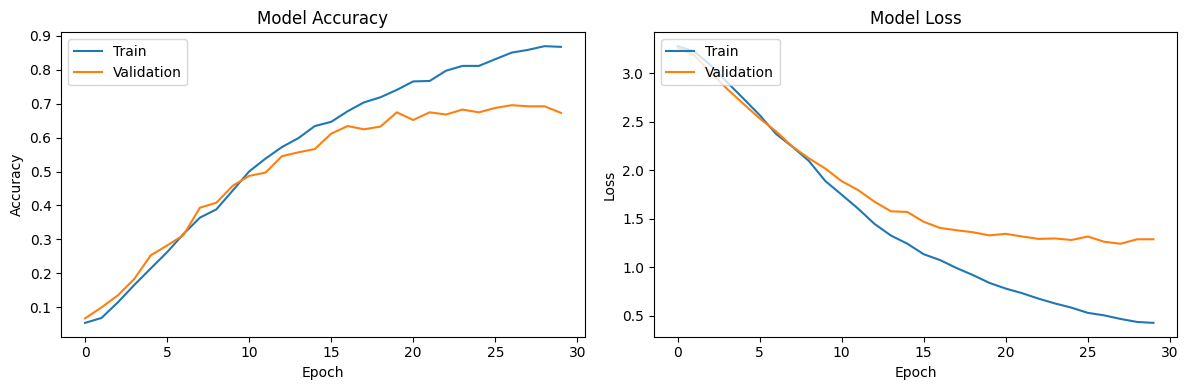

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
model.save('/content/drive/My Drive/PSL/model.h5')
print("Trained model saved successfully.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/My Drive/PSL/model.h5')
print("Trained model loaded successfully.")


Trained model loaded successfully.


In [ ]:
def predict_gesture(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Resize the image for prediction
    image_resized = cv2.resize(image, (100, 100))

    # Predict the label
    predicted_label = label_encoder.inverse_transform([np.argmax(model.predict(np.expand_dims(image_resized, axis=0)))])[0]

    return predicted_label


1/1 [==============================] - 0s 28ms/step
Predicted gesture for W_2_png.rf.e2cc9f97c3b3656f9adb9c727f93a1e0.jpg: W
1/1 [==============================] - 0s 24ms/step
Predicted gesture for N_2_png.rf.dc05ae7a829fef0279858fa04259e512.jpg: N
1/1 [==============================] - 0s 25ms/step
Predicted gesture for F_38_png.rf.4f4c9bdb96cfad92917ddf5561e2044f.jpg: F
1/1 [==============================] - 0s 26ms/step
Predicted gesture for Z_22_png.rf.c0aa237ad80e8ae78aac59e71c6b1c46.jpg: Z
1/1 [==============================] - 0s 25ms/step
Predicted gesture for X_35_png.rf.ee3c8bf7e07d171c5d6ce84bac05c2ef.jpg: Z
1/1 [==============================] - 0s 24ms/step


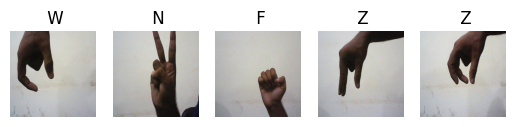

In [ ]:
# Path to your new images directory
new_images_dir = '/content/valid/valid/images'  # Update this with your new images directory

# List all files in the directory
new_image_files = os.listdir(new_images_dir)

# Choose a few random samples from the dataset
num_samples_to_display = 5
random_samples = random.sample(new_image_files, num_samples_to_display)

# Predict and print the gesture for each new image
for image_file in random_samples:
    image_path = os.path.join(new_images_dir, image_file)
    predicted_gesture = predict_gesture(image_path)
    print(f"Predicted gesture for {image_file}: {predicted_gesture}")


for i, image_file in enumerate(random_samples):
    image_path = os.path.join(new_images_dir, image_file)

    # Predict the gesture
    predicted_gesture = predict_gesture(image_path)

    # Read and plot the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image)
    plt.title(f" {predicted_gesture}")
    plt.axis('off')


20/20 [==============================] - 5s 275ms/step - loss: 1.2888 - accuracy: 0.6726
Test Loss: 1.2888, Test Accuracy: 0.6726
20/20 [==============================] - 5s 224ms/step


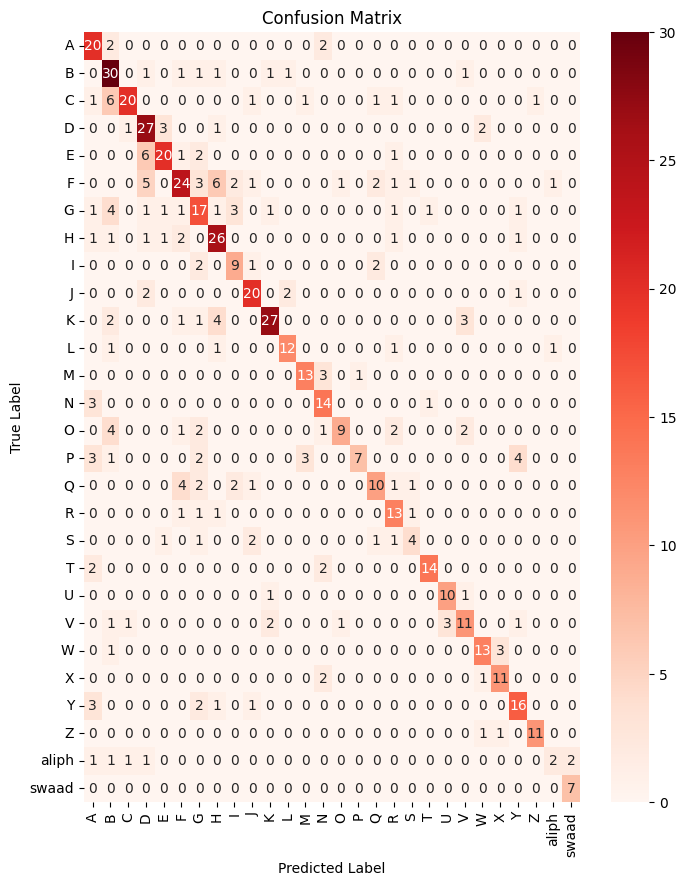

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Make predictions on the test set
y_pred = model.predict(X_test)
predicted_labels = [np.argmax(pred) for pred in y_pred]

# Generate confusion matrix
confusion_matrix_data = confusion_matrix(np.argmax(y_test, axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 10))
sns.heatmap(confusion_matrix_data, annot=True, cmap='Reds',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


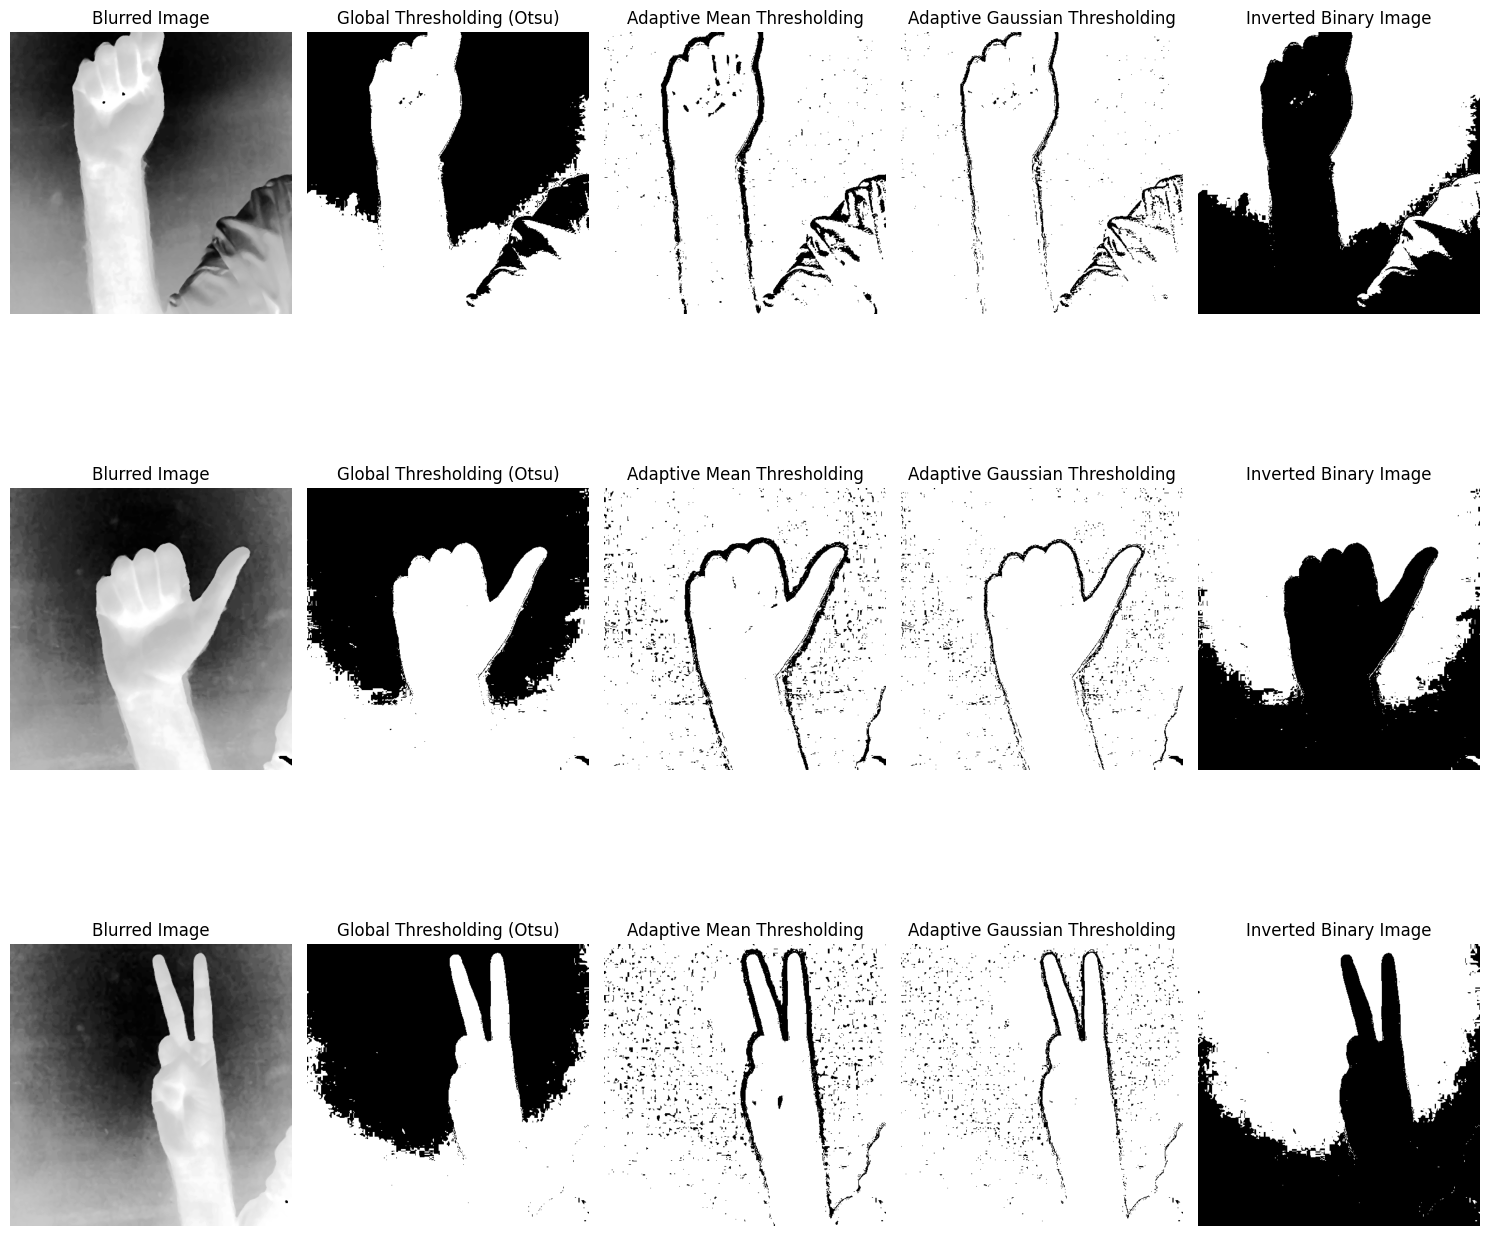

In [ ]:
# Function to apply thresholding techniques
def apply_thresholding(preprocessed_image):
    # Convert preprocessed image to uint8
    preprocessed_image_uint8 = (preprocessed_image * 255).astype('uint8')

    # Apply median blur to the preprocessed image
    blurred_image = cv2.medianBlur(preprocessed_image_uint8, 5)

    # Apply global thresholding
    ret, global_threshold = cv2.threshold(preprocessed_image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply adaptive mean thresholding
    adaptive_mean_threshold = cv2.adaptiveThreshold(preprocessed_image_uint8, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                                    cv2.THRESH_BINARY, 21, 10)

    # Apply adaptive Gaussian thresholding
    adaptive_gaussian_threshold = cv2.adaptiveThreshold(preprocessed_image_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                        cv2.THRESH_BINARY, 21, 10)

    # Invert the binary image obtained from global thresholding
    inverted_binary_image = cv2.bitwise_not(global_threshold.copy())

    return blurred_image, global_threshold, adaptive_mean_threshold, adaptive_gaussian_threshold, inverted_binary_image

# Function to preprocess, apply thresholding, and display images
def preprocess_and_apply_thresholding(image_directory, num_samples_to_display=3):
    # List all files in the directory
    image_files = os.listdir(image_directory)
    if not image_files:
        raise ValueError("No images found in the directory.")

    # Choose random samples from the dataset
    random_samples = random.sample(image_files, num_samples_to_display)

    plt.figure(figsize=(15, 5 * num_samples_to_display))

    for i, image_file in enumerate(random_samples):
        image_path = os.path.join(image_directory, image_file)

        # Read the image
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if original_image is None:
            print(f"Error: Image file '{image_file}' not found.")
            continue

        # Apply histogram equalization
        equalized_image = cv2.equalizeHist(original_image)

        # Apply thresholding
        blurred_image, global_threshold, adaptive_mean_threshold, adaptive_gaussian_threshold, inverted_binary_image = apply_thresholding(equalized_image)

        # Display the images
        plt.subplot(num_samples_to_display, 5, i * 5 + 1)
        plt.imshow(blurred_image, cmap='gray')
        plt.title('Blurred Image')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 5, i * 5 + 2)
        plt.imshow(global_threshold, cmap='gray')
        plt.title('Global Thresholding (Otsu)')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 5, i * 5 + 3)
        plt.imshow(adaptive_mean_threshold, cmap='gray')
        plt.title('Adaptive Mean Thresholding')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 5, i * 5 + 4)
        plt.imshow(adaptive_gaussian_threshold, cmap='gray')
        plt.title('Adaptive Gaussian Thresholding')
        plt.axis('off')

        plt.subplot(num_samples_to_display, 5, i * 5 + 5)
        plt.imshow(inverted_binary_image, cmap='gray')
        plt.title('Inverted Binary Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_directory = '/content/valid/valid/images/'
preprocess_and_apply_thresholding(image_directory, num_samples_to_display=3)

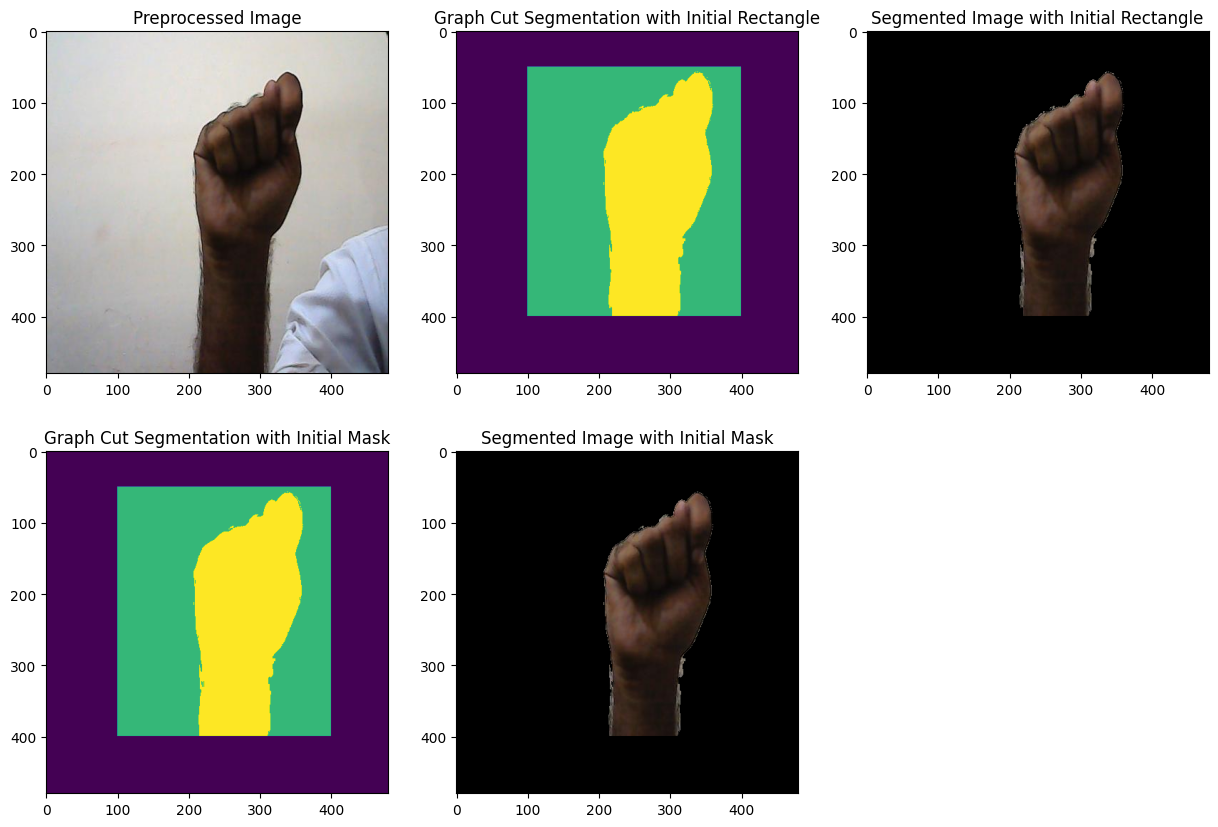

In [ ]:
def graphCutSeg():
    # Path to your images directory
    image_directory = '/content/test/test/images'

    # List all files in the directory
    image_files = os.listdir(image_directory)
    if not image_files:
        raise ValueError("No images found in the directory.")

    # Path to the first image (change as needed)
    first_img_path = os.path.join(image_directory, image_files[0])

    # Load the preprocessed image
    preprocessed_image = cv2.imread(first_img_path, 0)
    if preprocessed_image is None:
        raise ValueError("Failed to load the preprocessed image.")

    # Read the hand gesture image
    img = cv2.imread(first_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(231)
    plt.imshow(img)
    plt.title('Preprocessed Image')

    plt.subplot(232)
    rows, cols = preprocessed_image.shape
    mask = np.zeros((rows, cols), np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)

    # Adjust the coordinates for your hand gesture's region of interest (ROI)
    x0 = 100
    y0 = 50
    x1 = 400
    y1 = 400
    rect = (x0, y0, x1-x0, y1-y0)
    iter = 1

    # Perform graph cut segmentation with initial rectangle
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iter, cv2.GC_INIT_WITH_RECT)
    plt.imshow(mask)
    plt.title('Graph Cut Segmentation with Initial Rectangle')

    plt.subplot(233)
    # Create a binary mask where 1 represents the foreground and 0 represents the background
    maskGC = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    imgSeg = img * maskGC[:,:,np.newaxis]
    plt.imshow(imgSeg)
    plt.title('Segmented Image with Initial Rectangle')

    plt.subplot(234)
    # Read the corresponding mask image
    markedMaskPath = first_img_path.replace('images', 'masks').replace('.jpg', '_mask.png')
    markedMask = cv2.imread(markedMaskPath, cv2.IMREAD_GRAYSCALE)
    # Mark the pixels in the mask as foreground (1)
    mask[markedMask == 255] = 1
    # Perform graph cut segmentation with initial mask
    cv2.grabCut(img, mask, None, bgdModel, fgdModel, iter, cv2.GC_INIT_WITH_MASK)
    plt.imshow(mask)
    plt.title('Graph Cut Segmentation with Initial Mask')

    plt.subplot(235)
    # Create a binary mask where 1 represents the foreground and 0 represents the background
    maskGC = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    imgSeg = img * maskGC[:,:,np.newaxis]
    plt.imshow(imgSeg)
    plt.title('Segmented Image with Initial Mask')

    plt.show()

if __name__ == '__main__':
     graphCutSeg()

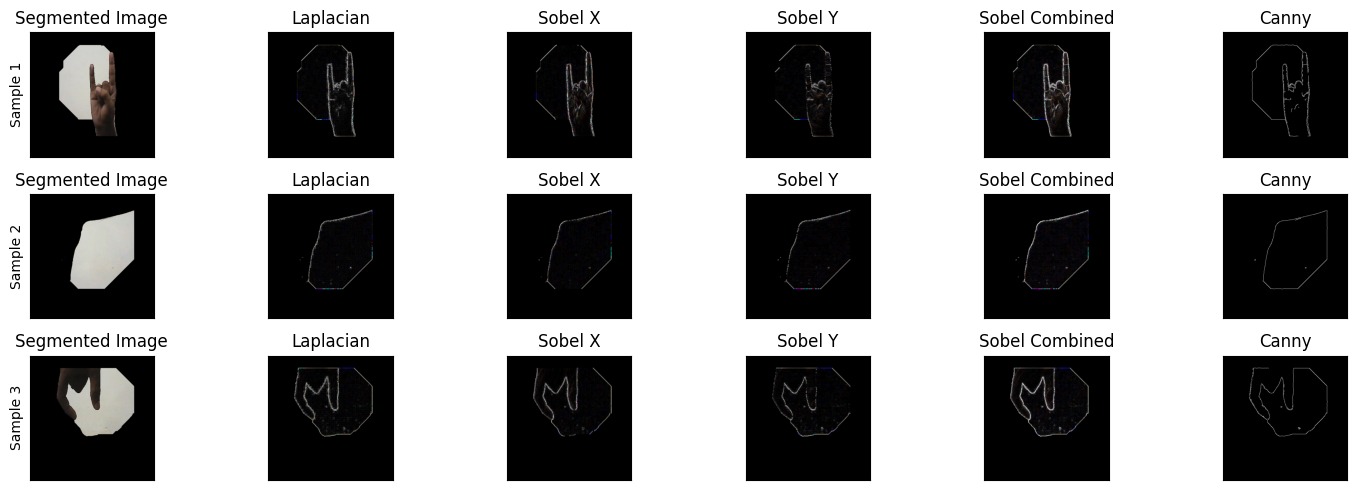

In [ ]:
def preprocess_image(image, size=(100, 100), apply_blur=False, invert_contrast=False, apply_threshold=False):
    # Apply Gaussian blur to remove noise
    if apply_blur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    # Invert contrast
    if invert_contrast:
        image = 255 - image

    # Apply global thresholding
    if apply_threshold:
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize the preprocessed image
    image = cv2.resize(image, size)

    # Normalize the image
    image = image.astype('float32') / 255.0

    return image

def preprocess_and_display_images(image_directory, num_samples_to_display=3):
    # List all files in the directory
    image_files = os.listdir(image_directory)
    if not image_files:
        raise ValueError("No images found in the directory.")

    # Choose a random sample of images from the dataset
    random_samples = random.sample(image_files, min(num_samples_to_display, len(image_files)))

    # Perform segmentation first for the random samples
    segmented_images = graphCutSeg(image_directory, random_samples)

    # Preprocess and display the segmented images
    plt.figure(figsize=(15, 5))

    for i, (image_file, segmented_image) in enumerate(segmented_images.items()):
        # Preprocess the segmented image
        preprocessed_image = preprocess_image(segmented_image, apply_blur=True, invert_contrast=True)

        # Apply various edge detection filters
        lap = cv2.Laplacian(segmented_image, cv2.CV_64F, ksize=3)
        lap = np.uint8(np.absolute(lap))
        sobelX = cv2.Sobel(segmented_image, cv2.CV_64F, 1, 0)
        sobelY = cv2.Sobel(segmented_image, cv2.CV_64F, 0, 1)
        canny = cv2.Canny(segmented_image, 100, 200)

        sobelX = np.uint8(np.absolute(sobelX))
        sobelY = np.uint8(np.absolute(sobelY))
        sobelCombined = cv2.bitwise_or(sobelX, sobelY)

        # Display the results
        titles = ['Segmented Image', 'Laplacian', 'Sobel X', 'Sobel Y', 'Sobel Combined', 'Canny']
        images = [segmented_image, lap, sobelX, sobelY, sobelCombined, canny]

        for j in range(6):
            plt.subplot(num_samples_to_display, 6, i * 6 + j + 1)
            plt.imshow(images[j], 'gray')
            plt.title(titles[j])
            plt.xticks([]), plt.yticks([])

            if j == 0:
                plt.ylabel(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()

def graphCutSeg(image_directory, image_files):
    segmented_images = {}
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_directory, image_file)

        # Load the preprocessed image
        preprocessed_image = cv2.imread(image_path, 0)
        if preprocessed_image is None:
            print(f"Failed to load the preprocessed image: {image_path}")
            continue

        # Read the hand gesture image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rows, cols = preprocessed_image.shape
        mask = np.zeros((rows, cols), np.uint8)
        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)

        # Adjust the coordinates for your hand gesture's region of interest (ROI)
        x0 = 100
        y0 = 50
        x1 = 400
        y1 = 400
        rect = (x0, y0, x1-x0, y1-y0)
        iter = 1

        # Perform graph cut segmentation with initial rectangle
        cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iter, cv2.GC_INIT_WITH_RECT)

        # Create a binary mask where 1 represents the foreground and 0 represents the background
        maskGC = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        imgSeg = img * maskGC[:,:,np.newaxis]

        segmented_images[image_file] = imgSeg

    return segmented_images

# Preprocess and display a subset of images
preprocess_and_display_images('/content/test/test/images/', num_samples_to_display=3)

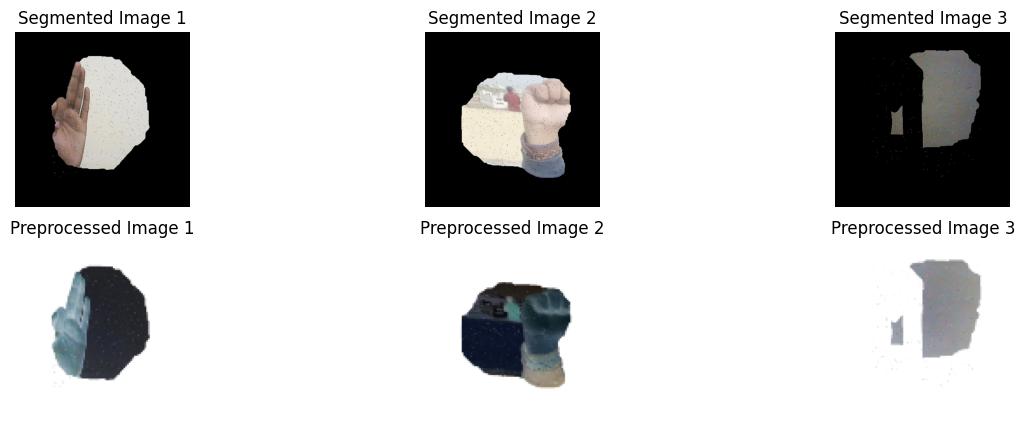

In [ ]:
def preprocess_and_display_images(image_directory, num_samples_to_display=3):
    # List all files in the directory
    image_files = os.listdir(image_directory)
    if not image_files:
        raise ValueError("No images found in the directory.")

    # Choose a random sample of images from the dataset
    random_samples = random.sample(image_files, min(num_samples_to_display, len(image_files)))

    # Perform segmentation first for the random samples
    segmented_images = graphCutSeg(image_directory, random_samples)

    # Preprocess and display the segmented images
    plt.figure(figsize=(15, 5))

    for i, (image_file, segmented_image) in enumerate(segmented_images.items()):
        # Preprocess the segmented image
        preprocessed_image = preprocess_image(segmented_image, apply_blur=True, invert_contrast=True)

        # Plot the segmented image
        plt.subplot(2, num_samples_to_display, i + 1)
        plt.imshow(segmented_image)
        plt.title(f"Segmented Image {i+1}")
        plt.axis('off')

        # Plot the preprocessed image
        plt.subplot(2, num_samples_to_display, num_samples_to_display + i + 1)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title(f"Preprocessed Image {i+1}")
        plt.axis('off')

    plt.show()

def graphCutSeg(image_directory, image_files):
    segmented_images = {}
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_directory, image_file)

        # Load the preprocessed image
        preprocessed_image = cv2.imread(image_path, 0)
        if preprocessed_image is None:
            print(f"Failed to load the preprocessed image: {image_path}")
            continue

        # Read the hand gesture image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rows, cols = preprocessed_image.shape
        mask = np.zeros((rows, cols), np.uint8)
        bgdModel = np.zeros((1,65), np.float64)
        fgdModel = np.zeros((1,65), np.float64)

        # Adjust the coordinates for your hand gesture's region of interest (ROI)
        x0 = 100
        y0 = 50
        x1 = 400
        y1 = 400
        rect = (x0, y0, x1-x0, y1-y0)
        iter = 1

        # Perform graph cut segmentation with initial rectangle
        cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iter, cv2.GC_INIT_WITH_RECT)

        # Create a binary mask where 1 represents the foreground and 0 represents the background
        maskGC = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        imgSeg = img * maskGC[:,:,np.newaxis]

        segmented_images[image_file] = imgSeg

    return segmented_images

# Preprocess and display a subset of images
preprocess_and_display_images('/content/train/train/images/', num_samples_to_display=3)